In [1]:
import math
import numpy as np
from scipy.stats import multivariate_normal
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

# State transition model

In [2]:
def f(x, u, w, dt):
    '''
    Arguments:
        x: state vectors (= [[x, y, theta], ...], shape of [n, 3])
        u: control input vector (= [v, omega], shape of [2,])
        w: control error vectors (= [[w_v, w_omega, gamma], ...], shape of [n, 3])
        dt: integral interval (scalar)
    Return:
        updated state vector (same shape w/ x)
    '''
    
    theta = x[:, 2]
    
    v = u[0] + w[:, 0]
    omega = u[1] + w[:, 1]
    gamma = w[:, 2]
    
    r = v / omega
    
    dx = -r * np.sin(theta) + r * np.sin(theta + omega * dt)
    dy =  r * np.cos(theta) - r * np.cos(theta + omega * dt)
    dtheta = omega * dt + gamma * dt
    
    delta = np.array([
        dx,
        dy,
        dtheta
    ]).T
    
    x_new = x + delta
    
    return x_new

# Observation model

In [3]:
def world2local(x, points):
    '''
    Arguments:
        x: state vectors (= [[x, y, theta], ...], shape of [n, 3])
        points: positions in world coordinate (= [[x1, y1], [x2, y2], ...], shape of [m, 2])
    Return:
        positions in local coordinates ( = [[[x1, y1], [x2, y2], ...], ...], shape of [n, m, 2])
    '''
    
    n = x.shape[0]
    m = points.shape[0]
    
    theta = x[:, 2] # shape of [n,]
    
    points = points[np.newaxis, :, :]     # shape of [1, m, 2]
    points = np.repeat(points, n, axis=0) # shape of [n, m, 2]
    x = x[:, np.newaxis, :2]              # shape of [n, 1, 2]
    d = points - x                        # shape of [n, m, 2]
    d = d[:, :, :, np.newaxis]            # shape of [n, m, 2, 1]
    
    cos, sin = np.cos(theta), np.sin(theta) # shape of [n,]
    rot = np.array([
        [ cos, sin],
        [-sin, cos]
    ])                               # shape of [2, 2, n]
    rot = rot.transpose(2, 0, 1)     # shape of [n, 2, 2]
    rot = rot[:, np.newaxis, :, :]   # shape of [n, 1, 2, 2]
    rot = np.repeat(rot, m, axis=1)  # shape of [n, m, 2, 2]
    
    points_local = rot @ d                  # shape of [n, m, 2, 1]
    points_local = points_local[:, :, :, 0] # shape of [n, m, 2]
    
    return points_local

In [4]:
landmarks = np.array([
    [ 5.0,  5.0],
    [ 2.0, -3.0],
    [-3.0,  4.0],
    [-5.0, -1.0],
    [ 0.0,  0.0]
])

def g(x, v):
    '''
    Arguments:
        x: state vectors (= [[x, y, theta], ...], shape of [n, 3])
        v: observation error vectors ( = [[[x1, y1], [x2, y2], ...], ...], shape of [n, m, 2])
    Return:
        landmark positions observed from local coordinates (same shape w/ v)
    '''
    
    z = world2local(x, landmarks)
    
    if v is not None:
        z += v
    
    return z

# Propagation of particle states

In [5]:
def calc_noise(n, true_val, var_coef):
    '''
    Arguments:
        n: number of the state vectors (particles)
        true_val: value before adding the noise
        var_coef: variance coefficient of the noise which follows normal distribution with zero mean
                  var = np.dot(u_var_coef, true_val**2)
    '''
    
    mean = np.zeros(shape=[var_coef.shape[0]])
    var = var_coef @ (true_val ** 2).T
    noise = multivariate_normal.rvs(mean, np.diag(var), n)
    
    return noise

In [6]:
# u_var_coef: coefficient of control error variance
# [var_v, var_omega, var_gamma] = np.dot(u_var_coef, u**2) 
u_var_coef = np.array([
    [0.25**2, 0.0],
    [0.0, 0.25**2],
    [0.0, 0.25**2]
])


def propagate(x_p, u, dt):
    '''
    Arguments:
        x_p: state vectors of the particles (= [[x, y, theta], ...], shape of [n, 3])
        u: control input vector (= [v, omega], shape of [2,])
        dt: integral interval (scalar)
    Return
        state vectors propagated by the state transition model (same shape w/ x_p)
    '''
    
    n = x_p.shape[0]
    
    w = calc_noise(n, u, u_var_coef)
    
    x_p = f(x_p, u, w, dt)
    
    return x_p

# Updation of particle likelihoods

In [7]:
def normalize_weights(likelihood):
    '''
    Arguments:
        likelihood: likelihoods of the particles (= [w1, w2, ...], shape of [n,])
    Return
        normalized likelihoods (same shape w/ likelihood)
    '''
    
    likelihood_sum = np.sum(likelihood)
    likelihood = likelihood / likelihood_sum
    
    #n = likelihood.shape[0]
    #likelihood[np.isnan(likelihood)] = 1.0 / float(n)
    
    #likelihood[np.isnan(likelihood)] = 0.0
    
    return likelihood

In [8]:
# z_var_coef: coefficient of observation error variance
# [var_z1, var_z2] = np.dot(z_var_coef, z**2) 
z_var_coef = np.array([
    [0.1**2, 0.0],
    [0.0, 0.1**2]
])

def update(x_p, z, likelihood):
    '''
    Arguments:
        x_p: state vectors of the particles (= [[x, y, theta], ...], shape of [n, 3])
        z: landmark positions observed from local coordinates ( = [[x1, y1], [x2, y2], ...], shape of [m, 2])
        likelihood: likelihoods of the particles (= [w1, w2, ...], shape of [n,])
    Return
        likelihoods updated by the obserbvation (same shape w/ likelihood)
    '''
    
    n = x_p.shape[0]
    m = z.shape[0]
    
    z_p = g(x_p, None)
    z_p = z_p.reshape(n, -1)
    
    mean = np.zeros(shape=[m * 2,])
    var = (z ** 2) @ z_var_coef
    cov = np.diag(var.flatten())
    
    z = z.flatten()
    z = z[np.newaxis, :]
    
    likelihood = multivariate_normal.pdf(z_p - z, mean, cov, allow_singular=True) * likelihood
    likelihood = normalize_weights(likelihood)
    
    return likelihood

# Resampling of particles

In [9]:
def resampling(x_p, likelihood, ess_thresh):
    '''
    Arguments:
        x_p: state vectors of the particles (= [[x, y, theta], ...], shape of [n, 3])
        likelihood: likelihoods of the particles (= [w1, w2, ...], shape of [n,])
    Return
        state vectors of the resampled particles (same size w/ x_p)
        likelihoods of the resampled particles (same size w/ likelihood)
    '''
    
    ess = np.reciprocal(likelihood @ likelihood.T)
    
    if ess >= ess_thresh:
        return x_p, likelihood, ess
    
    n = x_p.shape[0]
    
    likelihood_cum = np.cumsum(likelihood)
    resample_id = np.arange(0.0, 1.0, 1.0 / float(n)) + np.random.rand() / float(n)
    
    x_p_orig = np.copy(x_p)
    
    idx = 0
    for i in range(n):
        while resample_id[i] > likelihood_cum[idx]:
            idx += 1
        x_p[i] = x_p_orig[idx]
    
    likelihood = np.repeat(1.0 / float(n), n)
    
    return x_p, likelihood, ess

# Main

In [10]:
# System parameters

## Dynamics
__r = 10.0
__omega = math.radians(10.0)
__v = __r * __omega

__u_var_coef_sys = np.array([
    [0.25**2, 0.0],
    [0.0, 0.25**2],
    [0.0, 0.25**2]
])

## Observations
__z_var_coef_sys = np.array([
    [0.1**2, 0.0],
    [0.0, 0.1**2]
])

## Initial state
__x_true = np.array([
    [__r, 0.0, math.radians(90.0)]
])



# Particle filter parameters
__n = 500
__ess_thresh = __n * 0.05

__x_p = np.repeat(__x_true, __n, axis=0)
__likelihood = np.repeat(1.0 / float(__n), __n)



# Other parameters
__dt = 0.1
__m = landmarks.shape[0]

__step = 1000


x_rec = np.empty(shape=[__step, 3])
x_est_rec = np.empty(shape=[__step, 3])
max_idx_rec = np.empty(shape=[__step,])

for i in tqdm(range(__step)):
    # System
    
    ## State transition
    u = np.array([__v, __omega])
    w = calc_noise(1, u, __u_var_coef_sys)[np.newaxis,:]
    __x_true = f(__x_true, u, w, __dt)
    
    ## Observation
    z = g(__x_true, None)[0]
    v = calc_noise(__m, z, __z_var_coef_sys)
    z += v
    
    
    # Particle fileter
    
    ## Resampling
    __x_p, __likelihood, ess = resampling(__x_p, __likelihood, __ess_thresh)
    
    ## Proparation
    __x_p = propagate(__x_p, u, __dt)
    
    ## Updation
    __likelihood = update(__x_p, z, __likelihood)
    
    ## Get estimated state
    max_likelihood = np.max(__likelihood)
    max_idx = np.argmax(__likelihood)
    x_est = __x_p[max_idx]
    
    
    # Recording
    x_rec[i] = __x_true[0]
    x_est_rec[i] = x_est
    max_idx_rec[i] = max_idx

100%|██████████| 1000/1000 [00:03<00:00, 299.55it/s]


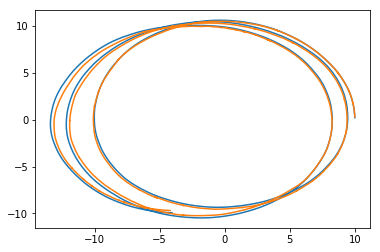

In [11]:
plt.plot(x_rec[:,0], x_rec[:,1])
plt.hold
plt.plot(x_est_rec[:,0], x_est_rec[:,1])

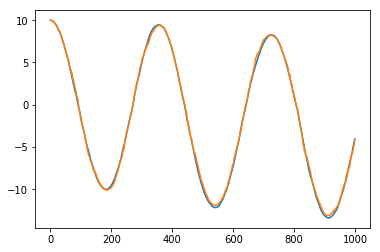

In [12]:
plt.plot(x_rec[:,0])
plt.hold
plt.plot(x_est_rec[:,0])

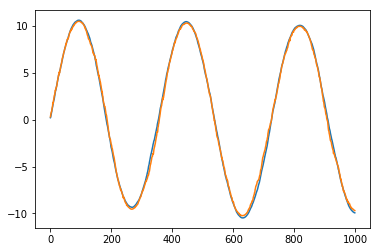

In [13]:
plt.plot(x_rec[:,1])
plt.hold
plt.plot(x_est_rec[:,1])

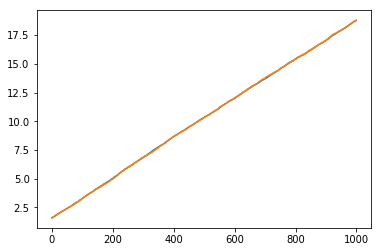

In [14]:
plt.plot(x_rec[:,2])
plt.hold
plt.plot(x_est_rec[:,2])